In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
from skimage.morphology import disk
import scipy.ndimage as ndimage

# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# February 21, 2019

## Image Enhancement

# Measurements are rarely perfect
<figure><img src="ext-figures/lecture03/imperfect_imaging_system.svg" style="height:300px" align="middle"></figure>

## Factors affecting the image quality
* Resolution (Imaging system transfer functions)
* Noise
* Contrast
* Inhomogeneous contrast
* Artifacts

No measurement system is perfect and therefore, you will also not get perfect images of the sample you measured. In the figure you can see the slice as it would be in a perfect world to the left and what you actually would measure with an imaging system. Some are of higher quality than others but there are still a collection of factors that have an impact on the image quality.
* __Resolution__ Thanks to the optical system there will be some unsharpness caused by scintillator, lenses, and camera. this appears as blurring or the acquired images.
* __Noise__ There are different sources of noise when an image is acquired. Most of them are Poisson/Binomial distributed point processes, but thanks to the light spread in the scintillator there can also be some spatially correlated noise.
* __Contrast__ Sometimes there is a very low intensity difference between different regions of the sample. This is in particularly problematic when the signal to noise ratio is low.
* __Inhomogeneous contrast__ The interaction between radiation and matter may introduce effects that appear as an inhomogeneous contrast. Typical such effects are beam hardening and scattering.
* __Artifacts__ The artifacts are features in the image that are not present in the sample. Often this is caused by detector errors or interference of radiation background or seconday radiation events.  


# A typical processing chain

<figure><img src="ext-figures/lecture03/image_proc_chain.svg" style="height:300px" align="middle"></figure>
Today's lecture will focus on the enhancement

Traditionally, the processing of image data can be divided into a series of sub tasks that provide the final resul. 
* __Acquisition__ The data must obviously be acquired and stored. There are cases when simulated data is used. Then, the acquisition is replaced by the process to simulate the data.
* __Enhancement__ The raw data is usually not ready to be processed in the form is comes from the acquisition. It usually has noise and artifacts as we saw on the previous slide. The enhancement step suppresses unwanted information in the data.
* __Segmentation__ The segmenation identifies different regions based on different features such as intensity distribution and shape.
* __Post processing__ After segmentation, there may be falsely identified regions. These are removed in a post processing step. 
* __Evaluation__ The last step of the process is to make conclusions based on the image data. It could be modelling material distrbutions, measuring shapes etc.

# Noise and artifacts
## The unwanted information

# Noise types
* Spatially uncorrelated noise
* Event noise
* Stuctured noise

### Noise examples

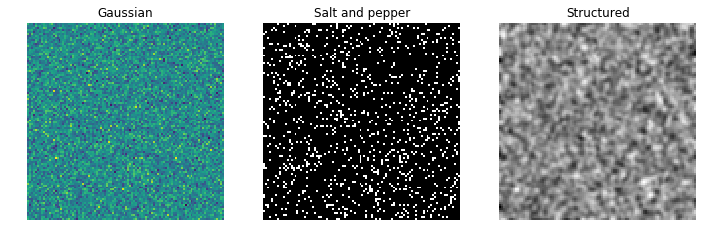

In [2]:
plt.figure(figsize=[12,5]);
plt.subplot(1,3,1);plt.imshow(np.random.normal(0,1,[100,100])); plt.title('Gaussian');plt.axis('off');
plt.subplot(1,3,2);plt.imshow(0.90<np.random.uniform(0,1,size=[100,100]),cmap='gray'); plt.title("Salt and pepper"),plt.axis('off');
plt.subplot(1,3,3);plt.imshow(ski.filters.gaussian(np.random.normal(0,1,size=[100,100]),sigma=1),cmap='gray'); plt.title("Structured"),plt.axis('off');

# Gaussian noise
* Additive
* Easy to model 
* Law of large numbers

### Distribution function
$n(x)=\frac{1}{\sqrt{2\pi\sigma}}\exp{-\left(\frac{x-\mu}{2\sigma}\right)^2}$

# Poisson noise
* Multiplicative
* Physically correct for event counting

### Distribition function 
$p(x)=\frac{\lambda^{k}}{k!} \exp{-\lambda\,x}$

# Compare Gaussian and Possion noise

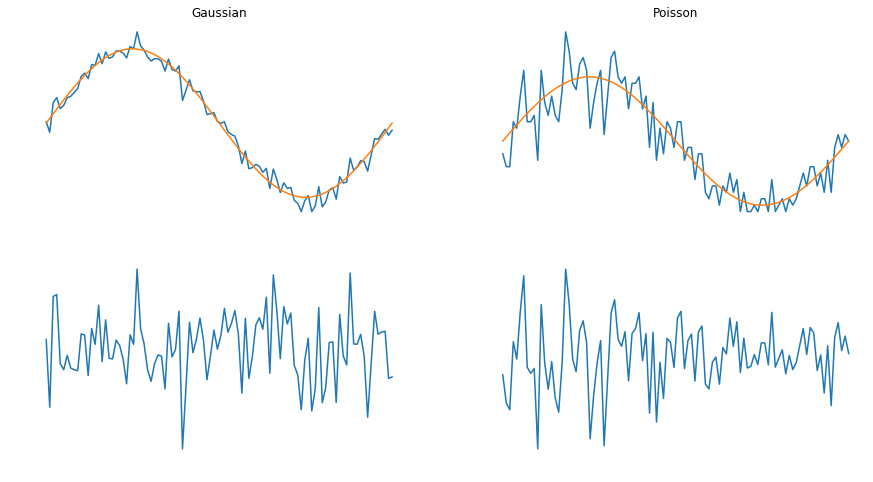

In [3]:
plt.figure(figsize=[15,8])
x=np.linspace(0,2*np.pi,100); 
y=10*np.sin(x)+11; ng=np.random.normal(0,1,size=len(x)); npoi = np.random.poisson(y);
plt.subplot(2,2,1); plt.plot(x,y+ng);plt.plot(x,y); plt.axis('off');plt.title('Gaussian'); plt.subplot(2,2,3);plt.plot(x,ng);plt.axis('off');
plt.subplot(2,2,2); plt.plot(x,npoi);plt.plot(x,y); plt.axis('off');plt.title('Poisson'); plt.subplot(2,2,4);plt.plot(x,npoi-y);plt.axis('off');

# Noise models - Salt'n'pepper noise
* A type of outlier noise
* Noise frequency described as probability of outlier
* Can be additive, multiplicative, and independent replacement

### Example model
$sp(x)=\left\{\begin{array}{ll}
-1 & x\leq\lambda_1\\ 
0 & \lambda_1< x \leq \lambda_2\\
1 & \lambda_2<x
\end{array}\right.\qquad \begin{array}{l}x\in\mathcal{U}(0,1)\\\lambda_1<\lambda_2\\
\lambda_1+\lambda_2 = \mbox{noise fraction}
\end{array}$

# Salt'n'pepper examples

In [4]:
def snp(dims,Pblack,Pwhite) : # Noise model function
    uni=np.random.uniform(0,1,dims)
    img=(Pwhite<uni).astype(float)-(uni<Pblack).astype(float)
    return img

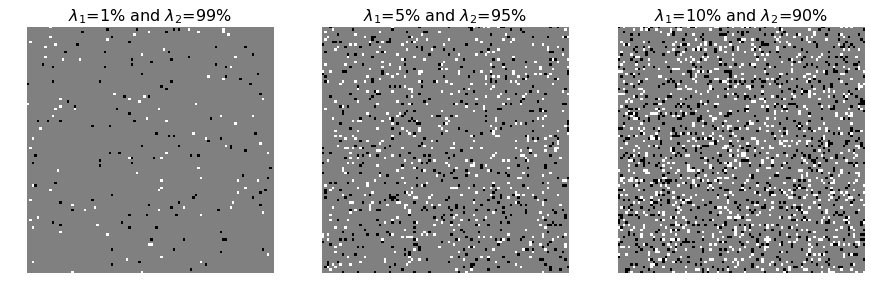

In [5]:
img10_90=snp([100,100],0.1,0.9); img5_95=snp([100,100],0.05,0.95);img1_99=snp([100,100],0.01,0.99)
plt.figure(figsize=[15,5])
plt.subplot(1,3,1); plt.imshow(img1_99,cmap='gray'); plt.title('$\lambda_1$=1% and $\lambda_2$=99%',fontsize=16); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(img5_95,cmap='gray'); plt.title('$\lambda_1$=5% and $\lambda_2$=95%',fontsize=16); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(img10_90,cmap='gray'); plt.title('$\lambda_1$=10% and $\lambda_2$=90%',fontsize=16); plt.axis('off');

## Signal to noise ratio

The Signal to noise ratio measures the noise strengh in a signal

### Definition

$SNR=\frac{mean(f)}{stddev(f)}$

## Signal to noise ratio for Poisson noise
- For a Poisson distribution the $SNR \sim \sqrt{N}$ 
- $N$ is the number of particles $\sim$ exposure time

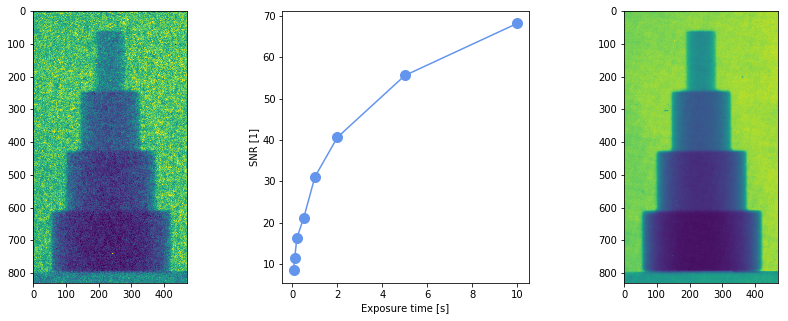

In [6]:
exptime=np.array([50,100,200,500,1000,2000,5000,10000])
snr = np.array([ 8.45949767, 11.40011621, 16.38118766, 21.12056507, 31.09116641,40.65323123, 55.60833117, 68.21108979]);
marker_style = dict(color='cornflowerblue', linestyle='-', marker='o',markersize=10, markerfacecoloralt='gray');
plt.figure(figsize=(15,5)) 
plt.subplot(1,3,2);plt.plot(exptime/1000,snr, **marker_style);plt.xlabel('Exposure time [s]');plt.ylabel('SNR [1]')
img50ms=plt.imread('ext-figures/lecture03/tower_50ms.png'); img10000ms=plt.imread('ext-figures/lecture03/tower_10000ms.png');
plt.subplot(1,3,1);plt.imshow(img50ms); plt.subplot(1,3,3); plt.imshow(img10000ms);

## Useful python functions

### Random number generators [numpy.random]
Generate an $m \times n$ random fields with different distributions:
* __Gauss__ ```np.random.normal(mu,sigma, size=[rows,cols])```
* __Uniform__ ```np.random.uniform(low,high,size=[rows,cols])```
* __Poisson__ ```np.random.poisson(lambda, size=[rows,cols])
	
### Statistics

* ```np.mean(f)```, ```np.var(f)```, ```np.std(f)``` Computes the mean, variance, and standard deviation of an image $f$.
* ```np.min(f)```,```np.max(f)``` Finds minimum and maximum values in $f$.
* ```np.median(f)```, ```np.rank()``` Selects different values from the sorted data.


# Basic filtering

## What is a filter?

### General definition
A filter is a processing unit that
* Enhances the wanted information 
* Suppresses the unwanted information

<div class="alert alert-block alert-warning">
Ideally without altering relevant features beyond recognition .
</div>



# Filter characteristics

Filters are characterized by the type of information they suppress

## Low-pass filters
* Slow changes are enhanced 
* Rapid changes are suppressed 
<figure><img src="ext-figures/lecture03/lp_principle.svg" style="height:300px" align="middle"></figure>

## High-pass filters
* Rapid changes are enhanced 
* Slow changes are suppressed
<figure><img src="ext-figures/lecture03/hp_principle.svg" style="height:300px" align="middle"></figure>

# Basic filters

## Linear filters
Computed using the convolution operation

$$g(x)=h*f(x)=\int_{\Omega}f(x-\tau) h(\tau) d\tau$$
where

* __$f$__ is the image 
* __$h$__ is the convolution kernel of the filter

<figure><img src="ext-figures/lecture03/filter_box.svg" style="height:150px" align="middle"></figure>

## Low-pass filter kernels
Low-pass filters suppress noise

### Mean or Box filter
All weights have the same value.

Example:
$$B=\frac{1}{25}\cdot\begin{array}{|c|c|c|c|c|}
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
\end{array}
$$

### Gauss filter
$$G=\exp{-\frac{x^2+y^2}{2\,\sigma^2}}$$
Example:
<figure><img src="ext-figures/lecture03/gauss_bell.svg" style="height:300px" align="middle"></figure>

## Using a Gauss filter

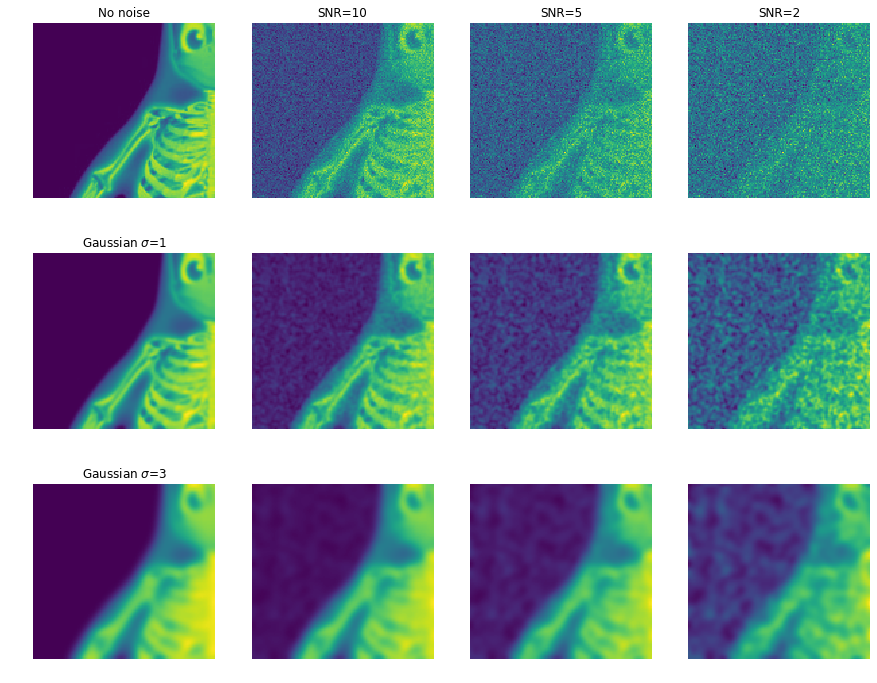

In [7]:
img = plt.imread('ext-figures/lecture03/input_orig.png'); 
noise = np.random.normal(0,1,size=img.shape); snr10=img+0.1*noise; snr5=img+0.2*noise; snr2=img+0.5*noise;plt.figure(figsize=[15,12])
plt.subplot(3,4,1); plt.imshow(img); plt.axis('off');plt.title('No noise'); plt.subplot(3,4,2); plt.imshow(snr10); plt.title('SNR=10'); plt.axis('off');plt.subplot(3,4,3); plt.imshow(snr5); plt.title('SNR=5'); plt.axis('off');plt.subplot(3,4,4); plt.imshow(snr2); plt.title('SNR=2'); plt.axis('off');
plt.subplot(3,4,5); plt.imshow(ski.filters.gaussian(img,sigma=1)); plt.title('Gaussian $\sigma$=1'); plt.axis('off');plt.subplot(3,4,6); plt.imshow(ski.filters.gaussian(snr10,sigma=1));  plt.axis('off');plt.subplot(3,4,7); plt.imshow(ski.filters.gaussian(snr5,sigma=1));  plt.axis('off');plt.subplot(3,4,8); plt.imshow(ski.filters.gaussian(snr2,sigma=1)); plt.axis('off');
plt.subplot(3,4,9); plt.imshow(ski.filters.gaussian(img,sigma=3)); plt.title('Gaussian $\sigma$=3'); plt.axis('off');plt.subplot(3,4,10); plt.imshow(ski.filters.gaussian(snr10,sigma=3));  plt.axis('off');plt.subplot(3,4,11); plt.imshow(ski.filters.gaussian(snr5,sigma=3));  plt.axis('off');plt.subplot(3,4,12); plt.imshow(ski.filters.gaussian(snr2,sigma=3)); plt.axis('off');

## How is the convolution computed

<figure><img src="ext-figures/lecture03/principle_mean_filter.svg" style="height:400px" align="middle"></figure>

<div class="alert alert-block alert-success">
For a non-uniform kernel each term is weighted by its kernel weight.
</div>

## Euclidean separability
The asociative and commutative laws apply to convoution

$$(a * b)*c=a*(b*c) \quad \mbox{ and } \quad a * b = b * a $$

A convolution kernel is called _separable_ if it can be split in two or more parts:
<font size="3">
$$\begin{array}{|c|c|c|}
\hline
\cdot & \cdot & \cdot\\
\hline
\cdot & \cdot & \cdot\\
\hline
\cdot & \cdot& \cdot\\
\hline
\end{array}=
\begin{array}{|c|}
\hline
\cdot \\
\hline
\cdot \\
\hline
\cdot \\
\hline
\end{array}
*
\begin{array}{|c|c|c|}
\hline
\cdot & \cdot & \cdot\\
\hline
\end{array}$$
</font>    

$$\exp{-\frac{x^2+y^2}{2\,\sigma^2}}=\exp{-\frac{x^2}{2\,\sigma^2}}*\exp{-\frac{y^2}{2\,\sigma^2}}$$

#### Gain
Separability reduces the number of computations $\rightarrow$ faster processing
- 3$\times$3 $\rightarrow$ 9 mult and 8 add $\Leftrightarrow$ 6 mult and 4 add
- 3$\times$3$\times$3 $\rightarrow$ 27 mult and 26 add $\Leftrightarrow$ 9 mult and 6 add


## The median filter
<figure><img src="ext-figures/lecture03/principle_median_filter.svg" style="height:400px" align="middle"></figure>

## Comparing filters for different noise types

/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


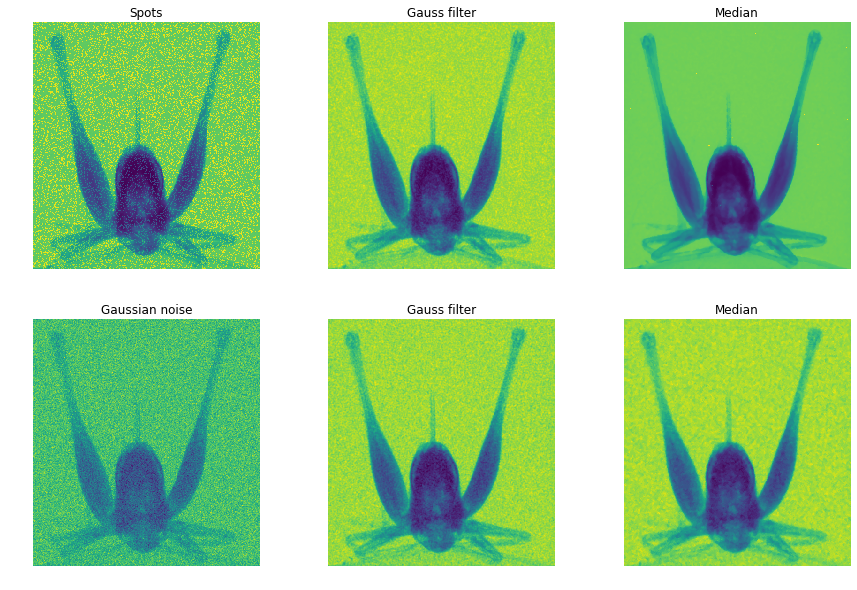

In [8]:
img = plt.imread('ext-figures/lecture03/grasshopper.png'); noise=img+np.random.normal(0,0.1,size=img.shape); spots=img+0.2*snp(img.shape,0,0.8); noise=(noise-noise.min())/(noise.max()-noise.min());spots=(spots-spots.min())/(spots.max()-spots.min())
plt.figure(figsize=[15,10])
plt.subplot(2,3,1); plt.imshow(spots); plt.title('Spots'); plt.axis('off');
plt.subplot(2,3,2); plt.imshow(ski.filters.gaussian(spots,sigma=1)); plt.title('Gauss filter'); plt.axis('off');
plt.subplot(2,3,3); plt.imshow(ski.filters.median(spots,disk(3))); plt.title('Median'); plt.axis('off');

plt.subplot(2,3,4); plt.imshow(noise); plt.title('Gaussian noise'); plt.axis('off');
plt.subplot(2,3,5); plt.imshow(ski.filters.gaussian(noise,sigma=1)); plt.title('Gauss filter'); plt.axis('off');
plt.subplot(2,3,6); plt.imshow(ski.filters.median(noise,disk(3))); plt.title('Median'); plt.axis('off');

## Filter example: Spot cleaning

### Problem
- Many neutron images are corrupted by spots that confuse following processing steps. 
- The amount, size, and intensity varies with many factors. 
### Solutions
- :-( Low pass filter
- :-( Median filter
- :-) Detect spots and replace by estimate

### Example
<figure><img src="ext-figures/lecture03/spotty_knot_closeup.png" style="height:400px" align="middle"></figure>

## Spot cleaning algorithm

<figure><img src="ext-figures/lecture03/spotclean_algorithm.svg" style="height:400px" align="middle"></figure>

#### Parameters

- $N$ Width of median filter.
- $k$ Threshold level for outlier detection.


## Spot cleaning - Compare performance
<figure><img src="ext-figures/lecture03/spotclean_compare.pdf"  style="height:500px" align="middle"></figure>

### The ImageJ ways

- __Despeckle__ Median ... please avoid this one!!!
- __Remove outliers__ Similar to cleaning described algorithm

## High-pass filters
High-pass filters enhance rapid changes $\rightarrow$ ideal for edge detection

### Typical high-pass filters:

#### Gradients
$$\frac{\partial}{\partial\,x}=\frac{1}{2}\cdot\begin{array}{|c|c|}
\hline
-1 & 1\\
\hline
\end{array}\qquad
\frac{\partial}{\partial\,x}=\frac{1}{32}\cdot\begin{array}{|c|c|c|}
\hline
-3 & 0 & 3\\
\hline
-10 & 0 & 10\\
\hline
-3 & 0 & 3\\
\hline
\end{array}
$$
#### Laplacian
$$
\bigtriangleup=\frac{1}{2}\cdot\begin{array}{|c|c|c|}
\hline
1 & 2 & 1\\
\hline
2 & -12 & 2\\
\hline
1 & 2 & 1\\
\hline
\end{array}
$$
#### Sobel
$$
G=|\nabla f|=\sqrt{\left(\frac{\partial}{\partial\,x}f\right)^2 + \left(\frac{\partial}{\partial\,y}f\right)^2}
$$


## Gradient example

#### Vertical edges
$\frac{\partial}{\partial x}=\frac{1}{32}\cdot\begin{array}{|c|c|c|}
\hline
-3 & 0 & 3\\
\hline
-10 & 0 & 10\\
\hline
-3 & 0 & 3\\
\hline
\end{array}$  

#### Horizontal egdges
$\frac{\partial}{\partial\,y}=\frac{1}{32}\cdot\begin{array}{|c|c|c|}
\hline
-3 & -10 & -3\\
\hline
0 & 0 & 0\\
\hline
3 & 10 & 3\\
\hline
\end{array}$

[Jaehne, 2005](https://doi.org/10.1007/3-540-27563-0)

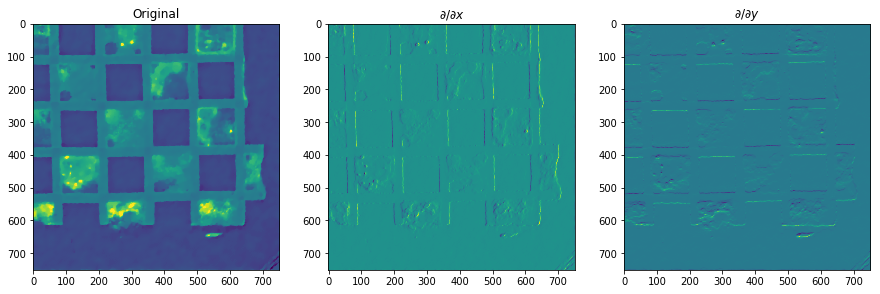

In [9]:
img=plt.imread('ext-figures/lecture03/orig.png')
k = np.array([[-3,-10,-3],[0,0,0],[3,10,3]]);
plt.figure(figsize=[15,8])
plt.subplot(1,3,1); plt.imshow(img);plt.title('Original');
plt.subplot(1,3,2); plt.imshow(ndimage.convolve(img,np.transpose(k)));plt.title('$\partial / \partial x$');
plt.subplot(1,3,3); plt.imshow(ndimage.convolve(img,k));plt.title('$\partial / \partial y$');

## Edge detection examples

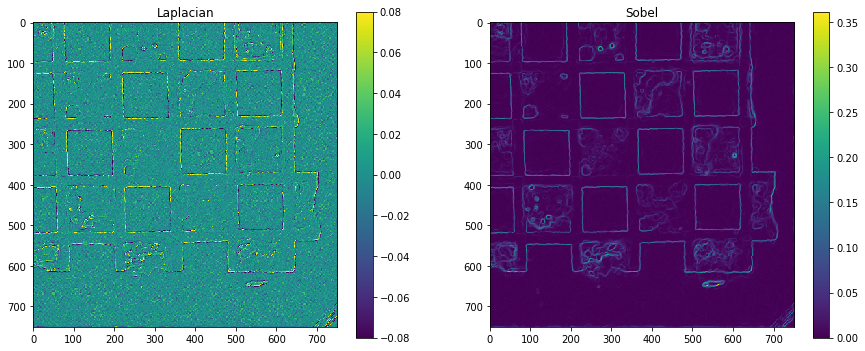

In [10]:
img=plt.imread('ext-figures/lecture03/orig.png');
plt.figure(figsize=[15,6])
plt.subplot(1,2,1);plt.imshow(ski.filters.laplace(img),clim=[-0.08,0.08]); plt.title('Laplacian'); plt.colorbar();
plt.subplot(1,2,2);plt.imshow(ski.filters.sobel(img)); plt.title('Sobel');  plt.colorbar();

## Relevance to machine learning
<center><img src="ext-figures/lecture03/convolutional_neural_network.png"  style="height:500px" align="middle"></center>
	
[NVIDIA Developer zone](https://developer.nvidia.com/discover/convolutional-neural-network)


# Frequency space filters
## Applications of the Fourier transform

## The Fourier transform
#### Transform
$$G(\xi_1,\xi_2)=\mathcal{F}\{g\}=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} g(x,y)
\exp{-i(\xi_1\,x+\xi_2\,y)}\,dx\,dy$$
#### Inverse
$$ g(x,y)=\mathcal{F}^{-1}\{G\}=\frac{1}{(2\,\pi)^2}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} G(\omega)
\exp{i(\xi_1\,x+\xi_2\,y)}\,d\xi_1 \,d\xi_2$$

### FFT (Fast Fourier Transform)
In practice - you never see the transform equations. 
The Fast Fourier Transform algorithm is available in numerical libraries and tools.

[Jaehne, 2005](https://doi.org/10.1007/3-540-27563-0)

## Some mathematical features of the FT
#### Additition
$\mathcal{F}\{a+b\} = \mathcal{F}\{a\}+\mathcal{F}\{b\}$

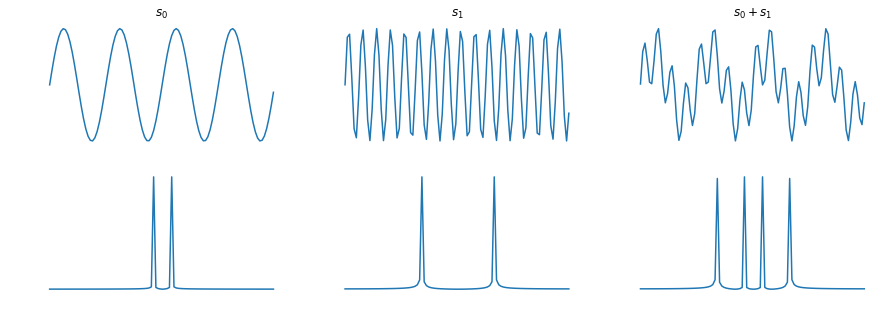

In [11]:
x = np.linspace(0,50,100); s0=np.sin(0.5*x); s1=np.sin(2*x);
plt.figure(figsize=[15,5])
plt.subplot(2,3,1);plt.plot(x,s0); plt.axis('off');plt.title('$s_0$');plt.subplot(2,3,4);plt.plot(np.abs(np.fft.fftshift(np.fft.fft(s0))));plt.axis('off');
plt.subplot(2,3,2);plt.plot(x,s1); plt.axis('off');plt.title('$s_1$');plt.subplot(2,3,5);plt.plot(np.abs(np.fft.fftshift(np.fft.fft(s1))));plt.axis('off');
plt.subplot(2,3,3);plt.plot(x,s0+s1); plt.axis('off');plt.title('$s_0+s_1$');plt.subplot(2,3,6);plt.plot(np.abs(np.fft.fftshift(np.fft.fft(s0+s1))));plt.axis('off');

#### Convolution
$\mathcal{F}\{a * b\} = \mathcal{F}\{a\} \cdot \mathcal{F}\{b\} $
$\mathcal{F}\{a \cdot b\} = \mathcal{F}\{a\} * \mathcal{F}\{b\} $

## Additive noise in Fourier space
#### Real space

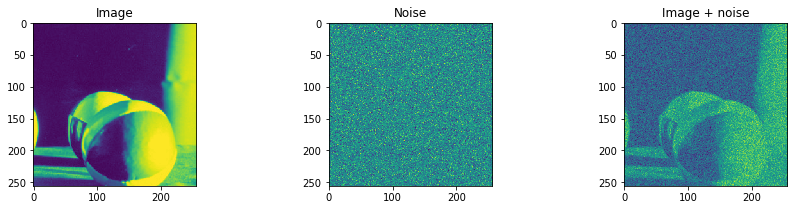

In [12]:
img=plt.imread('ext-figures/lecture03/bp_ex_original.png'); noise=np.random.normal(0,0.2,size=img.shape); nimg=img+noise;
plt.figure(figsize=[15,3])
plt.subplot(1,3,1); plt.imshow(img);plt.title('Image');
plt.subplot(1,3,2); plt.imshow(noise);plt.title('Noise');
plt.subplot(1,3,3); plt.imshow(nimg);plt.title('Image + noise');

#### Fourier space

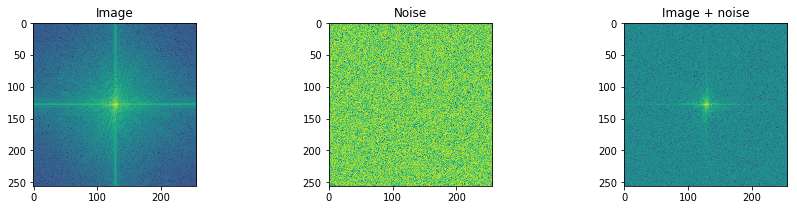

In [13]:
plt.figure(figsize=[15,3])
plt.subplot(1,3,1); plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(img)))));plt.title('Image');
plt.subplot(1,3,2); plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(noise)))));plt.title('Noise');
plt.subplot(1,3,3); plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(nimg)))));plt.title('Image + noise');

### Problem
How can we suppress noise without destroying relevant image features?

## Spatial frequencies and orientation

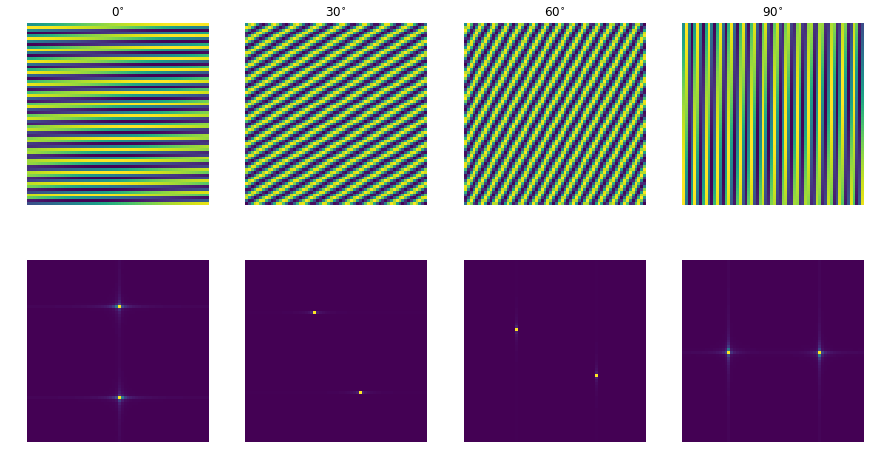

In [14]:
def ripple(size=128,angle=0,w0=0.1) :
    w=w0*np.linspace(0,1,size);
    [x,y]=np.meshgrid(w,w);
    img=np.sin((np.sin(angle)*x)+(np.cos(angle)*y));
    return img
N=64;
d0=ripple(N,angle=1/180*np.pi,w0=100);
d30=ripple(N,angle=30/180*np.pi,w0=100);
d60=ripple(N,angle=60/180*np.pi,w0=100);
d90=ripple(N,angle=89/180*np.pi,w0=100);
plt.figure(figsize=[15,8])
plt.subplot(2,4,1); plt.imshow(d0); plt.title('$0^{\circ}$'); plt.axis('off');
plt.subplot(2,4,2); plt.imshow(d30); plt.title('$30^{\circ}$'); plt.axis('off');
plt.subplot(2,4,3); plt.imshow(d60); plt.title('$60^{\circ}$'); plt.axis('off');
plt.subplot(2,4,4); plt.imshow(d90); plt.title('$90^{\circ}$'); plt.axis('off');

plt.subplot(2,4,5); plt.imshow((np.abs(np.fft.fftshift(np.fft.fft2(d0)))));   plt.axis('off');
plt.subplot(2,4,6); plt.imshow((np.abs(np.fft.fftshift(np.fft.fft2(d30)))));  plt.axis('off');
plt.subplot(2,4,7); plt.imshow((np.abs(np.fft.fftshift(np.fft.fft2(d60)))));  plt.axis('off');
plt.subplot(2,4,8); plt.imshow((np.abs(np.fft.fftshift(np.fft.fft2(d90)))));  plt.axis('off');

## Example - Stripe removal in Fourier space

- Transform the image to Fourier space
$$\mathcal{F_{2D}}\left\{a\right\} \Rightarrow A$$

- Multiply spectrum image by band pass filter
$$A_{filtered}=A \cdot H$$

- Compute the inverse transform to obtain the filtered image in real space
$$\mathcal{{F_{2D}}^{-1}}\left\{A_{filtered}\right\} \Rightarrow a_{filtered}$$

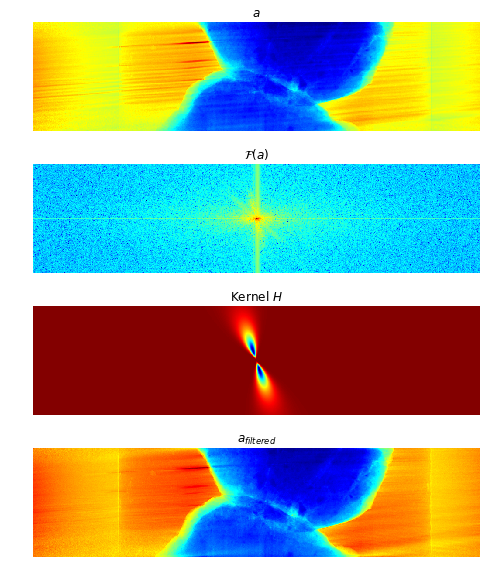

In [15]:
plt.figure(figsize=[8,10])
plt.subplot(4,1,1);plt.imshow(plt.imread('ext-figures/lecture03/raw_img.png')); plt.title('$a$'); plt.axis('off');
plt.subplot(4,1,2);plt.imshow(plt.imread('ext-figures/lecture03/raw_spec.png')); plt.title('$\mathcal{F}(a)$'); plt.axis('off');
plt.subplot(4,1,3);plt.imshow(plt.imread('ext-figures/lecture03/filt_spec.png')); plt.title('Kernel $H$'); plt.axis('off');
plt.subplot(4,1,4);plt.imshow(plt.imread('ext-figures/lecture03/filt_img.png')); plt.title('$a_{filtered}$'); plt.axis('off');

## The effect of the stripe filter

#### Reconstructed CT slice before filter

<center><img src="ext-figures/lecture03/slice_with_stripes.png"  style="height:400px" align="middle"></center>

#### Reconstructed CT slice after filter

<center><img src="ext-figures/lecture03/slice_stripe_filtered.png"  style="height:400px" align="middle"></center>

Intensity variations are suppressed using the stripe filter on all projections.

## Technical details
#### When should you use convolution in Fourier space?
-  Simplicity
-  Kernel size
-  Speed at repeated convolutions

#### Zero padding
The FFT is only working with data of size in $2^N$. If your data has a different length, you have to pad (fill with constant value) up the next $2^N$.

## Python functions
	
#### Filters in the spatial domain
e.g. from ```scipy import ndimage```
- ```ndimage.filters.convolve(f,h)``` Linear filter using kernel $h$ on image $f$.
- ```ndimage.filters.median_filter(f,\[n,m\])```  Median filter using an $n \times m$ filter neighborhood

#### Fourier transform
- ```np.fft.fft2(f)``` Computes the 2D Fast Fourier Transform of image $f$
- ```np.fft.ifft2(F)``` Computes the inverse Fast Fourier Transform $F$.

#### Complex numbers
- ```np.abs(f), np.angle(f)``` Computes amplitude and argument of a complex number.
- ```np.real(f), np.imag(f)``` Gives the real and imaginary parts of a complex number.

# Scale spaces

## Why scale spaces?
### Motivation
Basic filters have problems to handle low SNR and textured noise.\\
Something new is required\ldots
### The solution
Filtering on different scales can take noise suppression one step further.

scalespaces/burt_pyramid.pdf}

## Wavelets - the basic idea
- The wavelet transform produces scales by decomposing a signal into two signals at a coarser scale containing \emph{trend} and \emph{details}.\\
- The next scale is computed using the trend of the previous transform
$$WT\{s\}\rightarrow\{a_1,d_1\}, WT\{a_1\}\rightarrow\{a_2,d_2\}, \ldots, WT\{a_{N-1}\}\rightarrow\{a_N,d_N\} $$
- The inverse transform brings $s$ back using $\{a_N,d_1, \ldots,d_N\}$.
- Many wavelet bases exists, the choice depends on the application.

#### Applications of wavelets  
- Noise reduction 
- Analysis 
- Segmentation
- Compression
    
[Walker 2008](https://doi.org/10.1201/9781584887461) [Mallat 2009](https://doi.org/10.1016/B978-0-12-374370-1.X0001-8)

## Wavelet transform of a 1D signal

<center><img src="ext-figures/lecture03/wavelet1d_noaxis.svg" style="height:400px"></center>

Using __symlet-4__

## Wavelet transform of an image
<center><img src="ext-figures/lecture03/wt2d_schematic.svg" style="height:400px"></center>

## Wavelet transform of an image - example

#### <center>Original</center>
<center><img src="ext-figures/lecture03/testpattern_1024.png" style="height:400px"></center>

#### <center>Wavelet transformed</center>
<center><img src="ext-figures/lecture03/wt_testimage_gray.png" style="height:400px"></center>

## Wavelet noise reduction
The noise is found in the detail part of the WT
-  Make a WT of the signal to a level that corresponds to the scale of the unwanted information.
- Threshold the detail part $d_{\gamma}=|d|<\gamma \,?\, 0 : d$.
- Inverse WT back to normal scale $\rightarrow$ image is filtered.

<center><img src="ext-figures/lecture03/wavelet1d_filter.svg" style="height:400px"></center>

## Wavelet noise reduction - Image example
#### Example Filtered using two levels of Symlet-2 wavelet
__Data:__ Neutron CT of a lead scroll
<center><img src="ext-figures/lecture03/wavelet2d_filtered.svg" style="height:400px"></center>

## Python functions
%\begin{block}{dwt2/idtw2}
%Makes one level of the wavelet transform or its inverse using wavelet base specified by 'wn'. 
%\end{block}
%\begin{block}{wavedec2}
%Performs N levels of wavelet decomposition using a specified wavelet base.
%\end{block}
%\begin{block}{wbmpen}
%Estimating threshold parameters for wavelet denoising.
%\end{block}
%\begin{block}{wdencmp}
%Wavelet denoising and compression using information from \emph{wavedec2} and \emph{wbmpen}.
%\end{block}
%}

# Parameterized scale spaces

## PDE based scale space filters
<center><img src="ext-figures/lecture03/slice_original.pdf" style="height:400px"></center>
<center><img src="ext-figures/lecture03/slice_diffusion.pdf" style="height:400px"></center>
<center><img src="ext-figures/lecture03/slice_iss.pdf" style="height:400px"></center>

May work for applications where Linear and Rank filters fail.

[Aubert 2002](https://doi.org/10.1007/978-0-387-44588-5).

## The starting point
The heat transport equation
$$\frac{\partial T}{\partial t}=\kappa\,\nabla^2 T$$

- __$T$__ Image to filter (intensity $\equiv$ temperature)
- __$\kappa$__ Thermal conduction capacity

scalespaces/diffusion/bitumen.png

Original / Intensity diffusion

<center><img src="ext-figures/lecture03/lindiff.apng" style="height:300px"></center>
<div class="alert alert-block alert-warning">
<center>The steady state solution is a homogeneous image...</center>
</div>



## Controlling the diffusivity
We want to control the diffusion process\ldots\\
\begin{description}
\item{Near edges} The Diffusivity $\rightarrow$ 0
\item{Flat regions} The Diffusivity $\rightarrow$ 1
\end{description}

The contrast function $G$ is our control function
\begin{columns}
\begin{column}{0.5\textwidth}
\[G(x)=\frac{1}{1+\left(\frac{x}{\lambda}\right)^n}\]
\begin{itemize}
\item[$\lambda$] Threshold level
\item[$n$] Steepness of the threshold
\end{itemize}
\end{column}
\begin{column}{0.5\textwidth}
\begin{figure}
\includegraphics[width=\textwidth]{scalespaces/diffusion/DiffusionThresholds.pdf}
\end{figure}
\end{column}
\end{columns}
}

## Gradient controlled diffusivity
\begin{columns}
 \begin{column}{0.5\textwidth}
\[
\frac{\partial u}{\partial t}=G(|\nabla u|)\,\nabla^2 u
\]
\end{column}

\begin{column}{0.5\textwidth}
 \begin{tabular}{cc}
  \fboxsep 0.25pt\fbox{\includegraphics[width=0.45\textwidth]{scalespaces/diffusion/aggregates.png}} &
  \fboxsep 0.25pt\fbox{\includegraphics[width=0.45\textwidth]{scalespaces/diffusion/diffusivity.png}} \\
Image & Diffusivity map
 \end{tabular}
\end{column}
\end{columns}

\begin{itemize}
\item[$u$] Image to be filtered
\item[$G(\cdot)$] Non-linear function to control the diffusivity
\item[$\tau$] Time increment
\item[$N$] Number of iterations
\end{itemize}
\begin{center}
\framebox{This filter is noise sensitive!}
\end{center}
}

## The non-linear diffusion filter
A more robust filter is obtained with
\begin{equation}
\frac{\partial u}{\partial t}=G(|\nabla_{\sigma} u|)\,\nabla^2 u
\end{equation}
\begin{itemize}
\item[$u$] Image to be filtered
\item[$G(\cdot)$] Non-linear function to control the contrast
\item[$\tau$] Time increment per numerical iteration
\item[$N$] Number of iterations
\item[$\nabla_{\sigma}$] Gradient smoothed by a Gaussian filter, width $\sigma$
\end{itemize}
}

## Diffusion filter example
Neutron CT slice from a real-time experiment observing the coalescence of cold mixed bitumen.

\begin{figure}
\begin{tabular}{cc}
\includegraphics[width=0.4\textwidth]{scalespaces/diffusion/bitumen.png} &
% movie15 \includemovie[startat=frame:1,autoplay,repeat,toolbar,autostart]{0.4\textwidth}{0.4\textwidth}{nldif_iter.swf}\\
\includemedia[
activate=pageopen,
width=0.25\textwidth,
height=0.25\textwidth
]{}{nldif_iter.swf}
\\
Original & Iterations of non-linear diffusion
\end{tabular}
\end{figure}
\end{frame}

## Filtering as a regularization problem
### The continued development

- __90's__ During the late 90's the diffusion filter was described in terms of a regularization problem.
- __00's__ Work toward regularization of total variation minimization.

#### TV-L1
$$u=\underset{u\in BV(\Omega)}{\operatorname{argmin}}\left\{\underbrace{|u|_{BV}}_{noise}+ \underbrace{\mbox{$\frac{\lambda}{2}$}\|f-u\|_{1}}_{fidelity}\right\}$$
#### Rudin-Osher-Fatemi model (ROF)
$$u=\underset{u\in BV(\Omega)}{\operatorname{argmin}}\left\{\underbrace{|u|_{BV}}_{noise}+ \underbrace{\mbox{$\frac{\lambda}{2}$}\|f-u\|^2_{2}}_{fidelity}\right\}$$

with $|u|_{BV}=\int_{\Omega}|\nabla u|^2$


## The inverse scale space filter
\normalsize
\begin{block}{The idea} 
We want smooth regions with sharp edges\ldots

\begin{itemize}
\item Turn the processing order of scale space filter upside down
\item Start with an empty image
\item Add large structures successively until an image with relevant features appears
\end{itemize}
\end{block}
\begin{block}{The ISS filter -- Some properties}
\begin{itemize}
\item is an edge preserving filter for noise reduction.
\item is defined by a partial differential equation.
\item has a well defined termination point.
\end{itemize}
\end{block}
\hfill\cite{burger2006}
}

## The ROF filter equation
The image $f$ is filtered by solving
\begin{eqnarray}
\frac{\partial u}{\partial t}&=& \mathrm{div}\left(\frac{\nabla u}{|\nabla u|}\right)+\lambda\,(f-u+v)\nonumber\\
\frac{\partial v}{\partial t}&=& \alpha\, (f-u)
\end{eqnarray}
\vskip5pt
Variables:
\small
\begin{itemize}
\item[$f$] Input image
\item[$u$] Filtered image
\item[$v$] Regularization term (feedback of previous iteration)
\end{itemize}
\normalsize
Filter parameters
\small
\begin{itemize}
\item[$\lambda$] Related to the scale of the features to suppress.
\item[$\alpha$] Quality refinement
\item[$N$] Number of iterations
\item[$\tau$] Time increment
\end{itemize}
\normalsize
}

## Filter iterations
Neutron CT of dried lung filtered using 3D ISS filter
\begin{figure}
\begin{tabular}{cc}
\includegraphics[width=0.4\textwidth]{scalespaces/iss/lung_iterations_first.png} &
% movie15 \includemovie[startat=frame:1,autoplay,repeat,toolbar,autostart]{0.4\textwidth}{0.4\textwidth}{filter_iterations.swf}\\
\includemedia[
activate=pageopen,
width=0.4\textwidth,
height=0.4\textwidth
]{}{filter_iterations.swf}
\\
Original & Filter iterations
\end{tabular}
\end{figure}
}

## How to choose $\lambda$ and $\alpha$
The requirements varies between different data sets.

#### Initial conditions:
- Signal to noise ratio
- Image features (fine grained or wide spread)

#### Experiment:
- Scan $\lambda$ and $\alpha$
- Stop at $T=n\, \tau= \sigma$ use different $\tau$
- When does different effects occur, related to $\sigma$?

## Solutions at different times}
\centering
\begin{tabular}{ccccc}
 \includegraphics[width=0.15\textwidth]{scalespaces/iss/iteration_0001.png} &
\includegraphics[width=0.15\textwidth]{scalespaces/iss/iteration_0030.png} &
\includegraphics[width=0.15\textwidth]{scalespaces/iss/iteration_0060.png} &
\includegraphics[width=0.15\textwidth]{scalespaces/iss/iteration_0100.png} &
\includegraphics[width=0.15\textwidth]{scalespaces/iss/iteration_0200.png}\\
1 & 30 & 60 & 100 & 200
\end{tabular}
\begin{columns}[T]
 \begin{column}{0.62\textwidth}
\centering
  \includegraphics[width=0.75\textwidth]{scalespaces/iss/errorplot.pdf}\\
 \end{column}
 \begin{column}{0.15\textwidth}
\centering
\includegraphics[width=\textwidth]{scalespaces/iss/iteration_0500.png}\\500\\
\vskip5pt
\includegraphics[width=\textwidth]{scalespaces/iss/iteration_0999.png}\\999
 \end{column}
\end{columns}
}


%\frame{\frametitle{Solution time}
%The solution time ($T=N\cdot\tau$) is essential to the result
%\begin{itemize}
%\item[$\tau$ large] The solution is reached fast
%\item[$\tau$ small] The numerical accuracy is better
%\end{itemize}
%}

\begin{frame}<beamer:0>
\frametitle{The choice of initial image}
\begin{figure}
\includegraphics[width=\textwidth]{scalespaces/iss/errorplots_initialimage.pdf}
\end{figure}
\vskip5pt
At some $T$ the solution with $u_0=f$ and $u_0=0$ converge.
\end{frame}
\subsection{Non-local means}
\frame[c	]{\frametitle{Non-local smoothing}
\begin{block}{The idea}
Smoothing normally consider information from the neighborhood like
\begin{itemize}
\item Local averages (convolution)
\item Gradients and Curvatures (PDE filters)
\end{itemize}
Non-local smoothing average similiar intensities in a global sense.
\begin{itemize}
\item Every filtered pixel is a weighted average of all pixels.
\item Weights computed using difference between pixel intensities.
\end{itemize}
\end{block}
\vfill\hfill\small\cite{buades2005_NLM}
}

\frame{\frametitle{Filter definition}
The non-local means filter is defined as
\begin{equation}
u(p)=\frac{1}{C(p)}\sum_{q\in\Omega}v(q)\,f(p,q)\label{eq_nlmdef}
\end{equation}
where
\begin{description}
\item[$v$ and $u$] input and result images.
\item[$C(p)$] is the sum of all pixel weights as 
\begin{equation}
C(p)=\sum_{q\in\Omega}f(p,q)\label{eq_nlmweightsum}
\end{equation}
\item[$f(p,q)$] is the weighting function
\begin{equation}
f(p,q)=e^{-\frac{|B(q)-B(p)|^2}{h^2}}
\end{equation}
\item[B(x)] is a neighborhood operator e.g. local average around $x$
\end{description}

}

\frame[c]{\frametitle{Non-local means 2D -- Example}
\includegraphics[width=\textwidth]{scalespaces/nonlocal_example.png}
\begin{block}{Observations}
\begin{itemize}
\item Good smoothing effect.
\item Strong thin lines are preserved.
\item Some patchiness related to filter parameter $t$, \emph{i.e.} the size of $\Omega_i$.
\end{itemize}
\end{block}
}
\frame{\frametitle{Performance complications}
\begin{block}{Problem}
The orignal filter compares all pixels with all pixels\ldots\\
\begin{itemize}
\item Complexity $\mathcal{O}(N^2)$ 
\item Not feasible for large images, and particular 3D images!
\end{itemize}
\end{block}
\begin{block}{Solution}
It has been shown that not all pixels have to be compared to achieve a good filter effect.\\
i.e. $\Omega$ in eq \ref{eq_nlmdef} and \ref{eq_nlmweightsum} can be replaced by $\Omega_i<<\Omega$ 
\end{block}
}